# 1. Import Libraries

In [81]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment


# 2. Load Data

In [83]:
data = pd.read_csv('../Dataset/gold_price.csv', parse_dates=True, index_col='Date').dropna()
data

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481
...,...,...,...,...,...,...
2019-08-27,1531.85,1532.95,1250.910,1247.510,1378.970,1380.880
2019-08-28,1541.75,1537.15,1263.310,1258.770,1389.890,1387.430
2019-08-29,1536.65,1540.20,1260.510,1262.960,1387.290,1392.030


# 3. Initial Analysis

### 3.1. Metadata

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4682 entries, 2001-01-02 to 2019-09-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USD (AM)   4682 non-null   float64
 1   USD (PM)   4682 non-null   float64
 2   GBP (AM)   4682 non-null   float64
 3   GBP (PM)   4682 non-null   float64
 4   EURO (AM)  4682 non-null   float64
 5   EURO (PM)  4682 non-null   float64
dtypes: float64(6)
memory usage: 256.0 KB


In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
USD (AM),4682.0,960.028236,449.654088,256.700,448.80000,1113.2500,1293.90000,1896.50
USD (PM),4682.0,959.728684,449.487106,255.950,448.61250,1112.2750,1294.22500,1895.00
GBP (AM),4682.0,625.083943,324.619479,176.572,244.48450,717.2980,939.06550,1265.90
GBP (PM),4682.0,624.921846,324.544149,176.441,244.46350,716.2105,939.26650,1265.01
EURO (AM),4682.0,773.955496,351.691333,276.711,360.88250,875.6085,1086.02825,1389.89
EURO (PM),4682.0,773.843716,351.696708,277.667,361.33875,875.1415,1085.81625,1392.03


In [12]:
data.isnull().sum()

USD (AM)     0
USD (PM)     0
GBP (AM)     0
GBP (PM)     0
EURO (AM)    0
EURO (PM)    0
dtype: int64

In [13]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Columns Processing

In [84]:
data['Return'] = data['USD (PM)'].pct_change() * 100
data['Lagged_Return'] = data['Return'].shift()
data = data.dropna()

In [85]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['USD (AM)', 'USD (PM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)', 'Return', 'Lagged_Return']
Categorical Columns : []


### 3.3. EDA

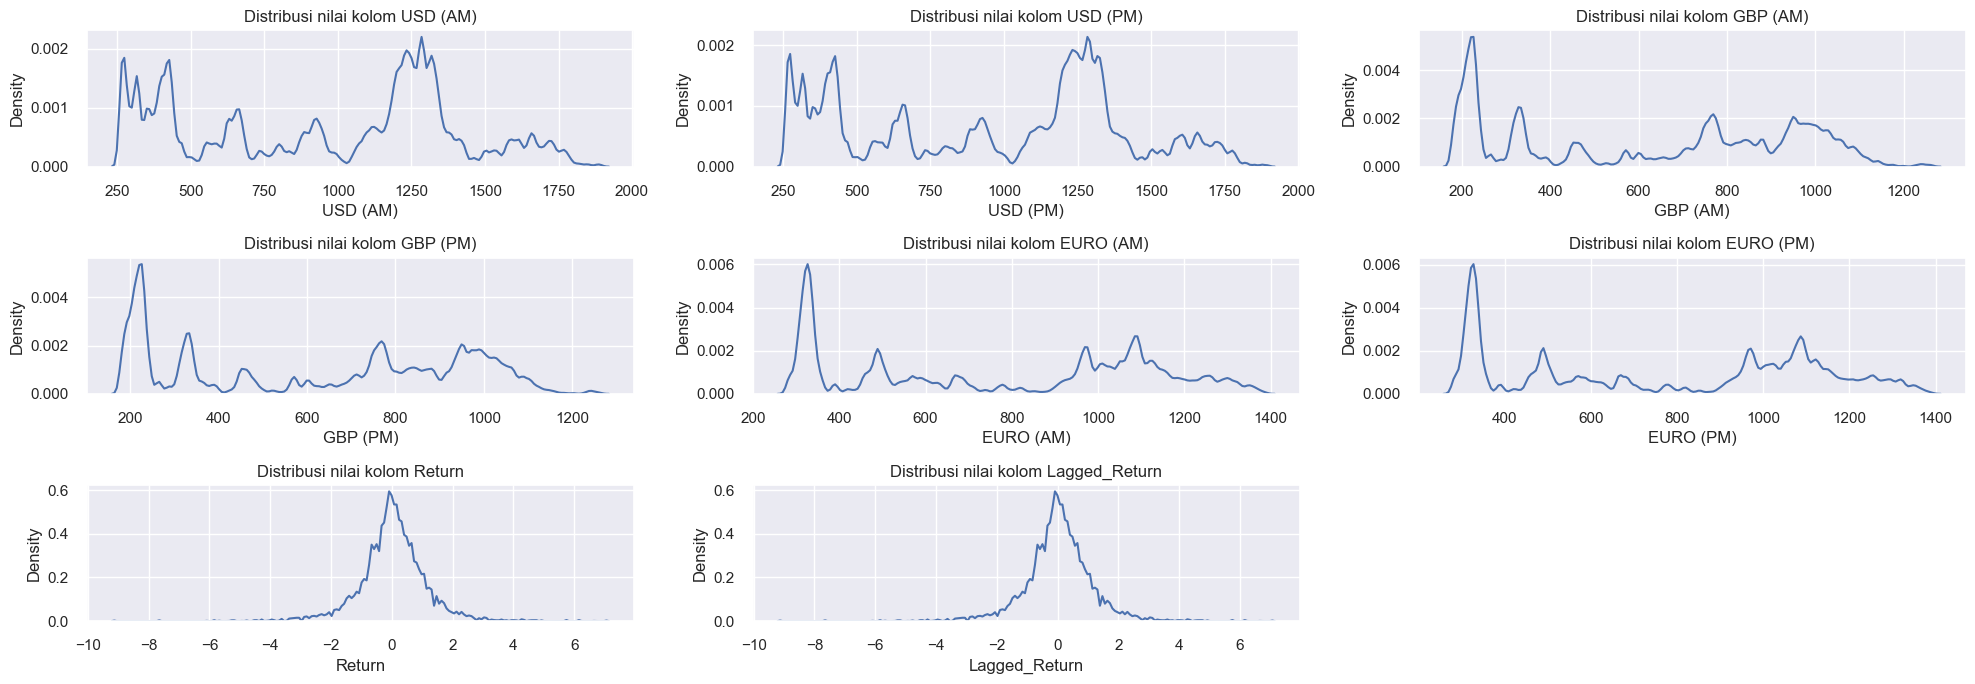

In [27]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="cut", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

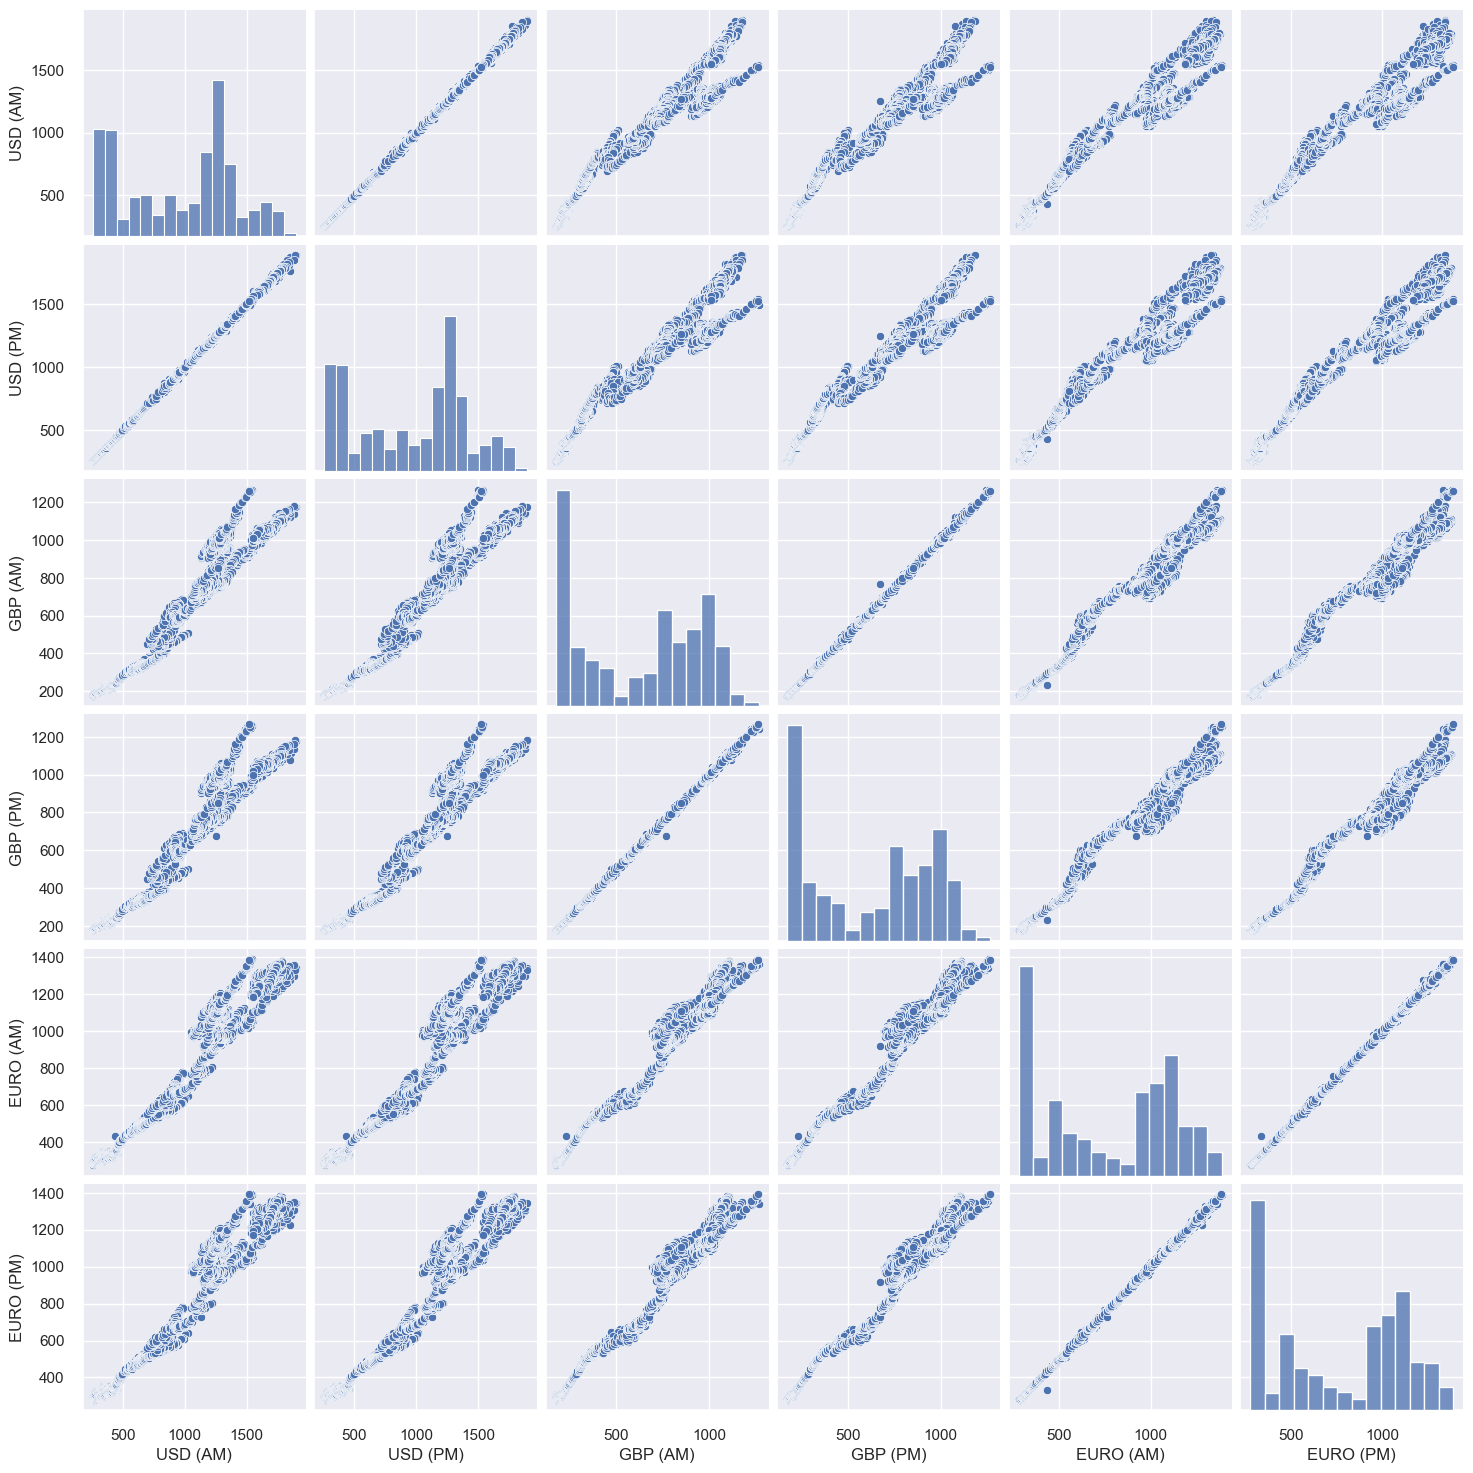

In [19]:
sns.pairplot(data)

In [ ]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
ax.bar_label(ax.containers[0])

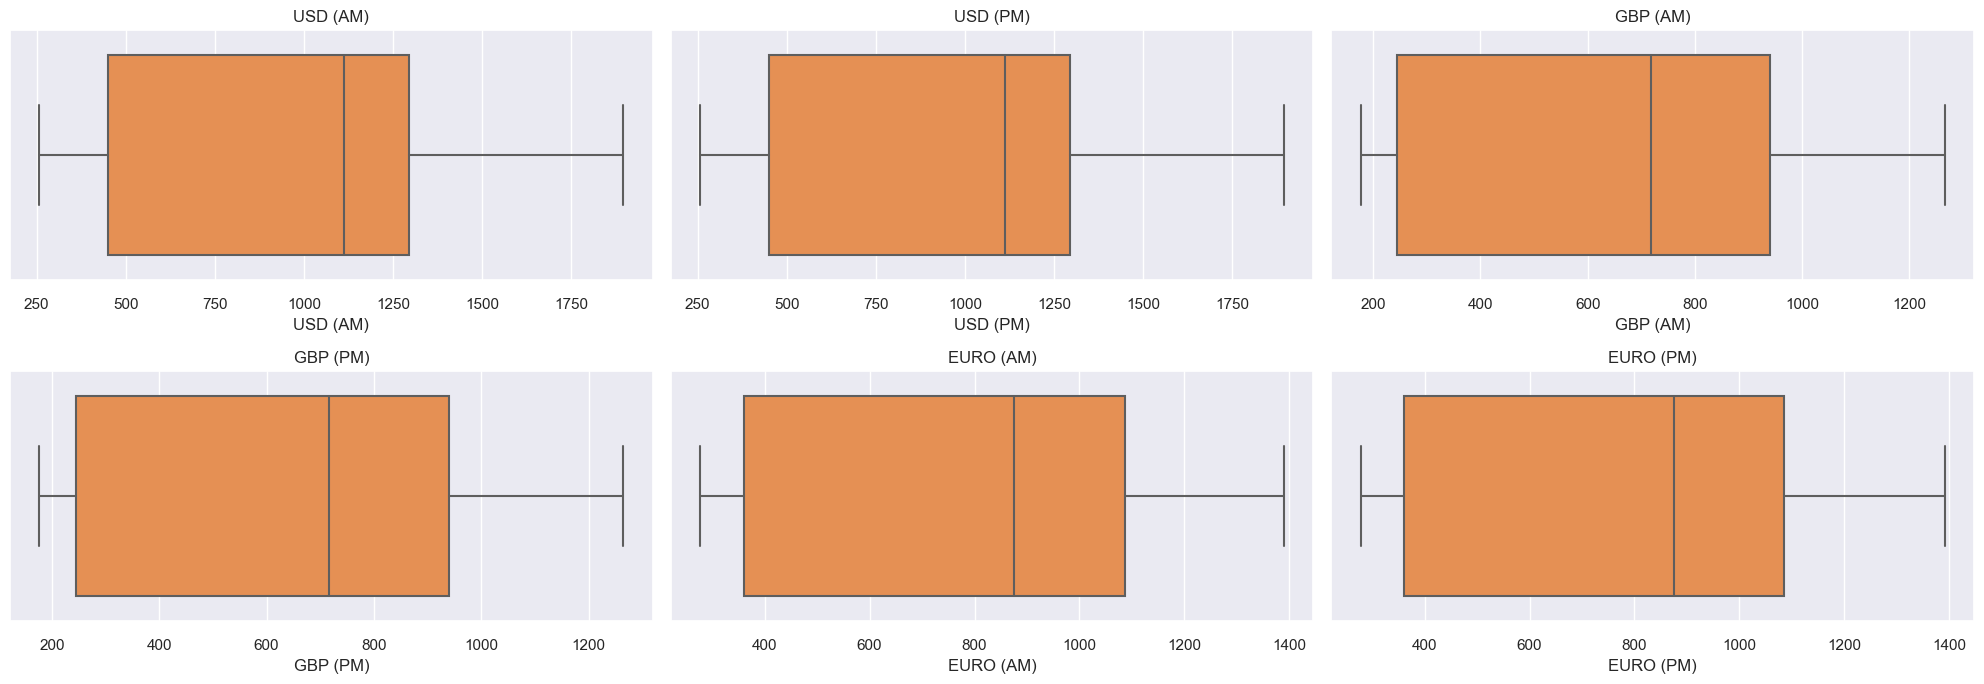

In [20]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

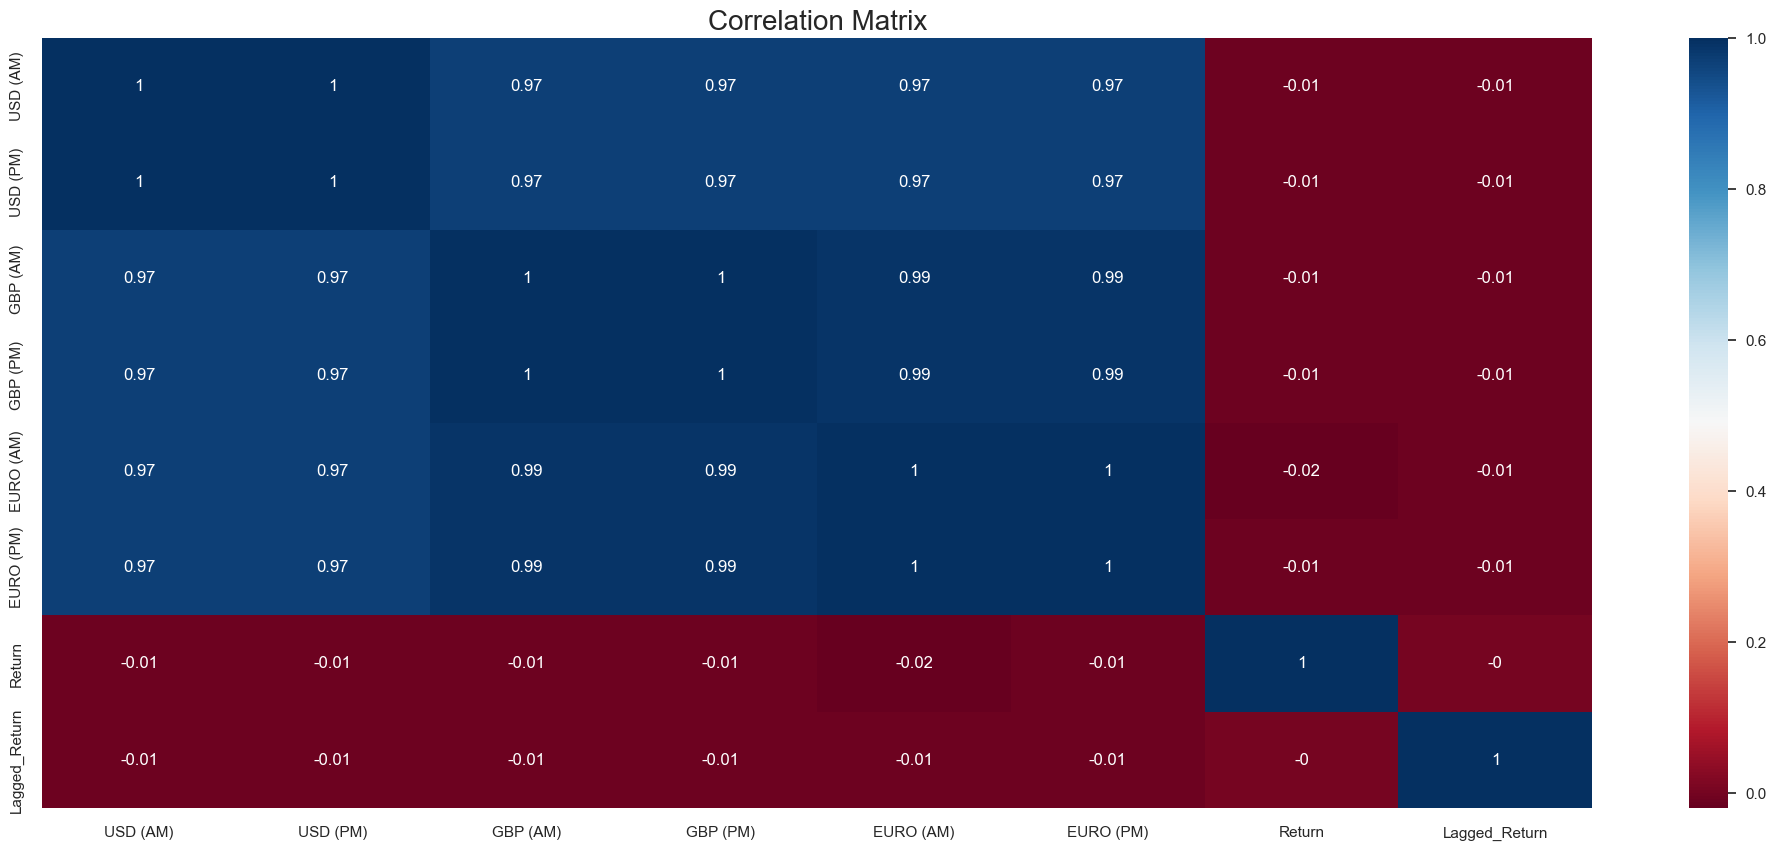

In [28]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [53]:
train = data['2001':'2018']
test = data['2019']

X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]

X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [102]:
X = data.drop(columns=['USD (AM)'])
Y = data['USD (AM)']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3285, 7)
(927, 7)
(468, 7)


# 5. Neural Network Algoritms

In [126]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mae', optimizer = opt)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 7, 256)            198912    
                                                                 
 gru_25 (GRU)                (None, 256)               394752    
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 593,921
Trainable params: 593,921
Non-trainable params: 0
_________________________________________________________________


In [128]:
num_epoch = 500
batch_size = 64

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/500
52/52 - 1s - loss: 374.7947 - val_loss: 378.1426 - 615ms/epoch - 12ms/step
Epoch 2/500
52/52 - 0s - loss: 373.9820 - val_loss: 377.7879 - 413ms/epoch - 8ms/step
Epoch 3/500
52/52 - 0s - loss: 373.3987 - val_loss: 377.3682 - 321ms/epoch - 6ms/step
Epoch 4/500
52/52 - 0s - loss: 372.4820 - val_loss: 375.6299 - 322ms/epoch - 6ms/step
Epoch 5/500
52/52 - 0s - loss: 371.6494 - val_loss: 374.6712 - 331ms/epoch - 6ms/step
Epoch 6/500
52/52 - 0s - loss: 370.8246 - val_loss: 373.9334 - 320ms/epoch - 6ms/step
Epoch 7/500
52/52 - 0s - loss: 369.8006 - val_loss: 372.9592 - 331ms/epoch - 6ms/step
Epoch 8/500
52/52 - 0s - loss: 369.2348 - val_loss: 372.5678 - 327ms/epoch - 6ms/step
Epoch 9/500
52/52 - 0s - loss: 368.4756 - val_loss: 371.5345 - 330ms/epoch - 6ms/step
Epoch 10/500
52/52 - 0s - loss: 367.3552 - val_loss: 370.5414 - 326ms/epoch - 6ms/step
Epoch 11/500
52/52 - 0s - loss: 366.6069 - val_loss: 369.5344 - 337ms/epoch - 6ms/step
Epoch 12/500
52/52 - 0s - loss: 365.7977 - val_loss

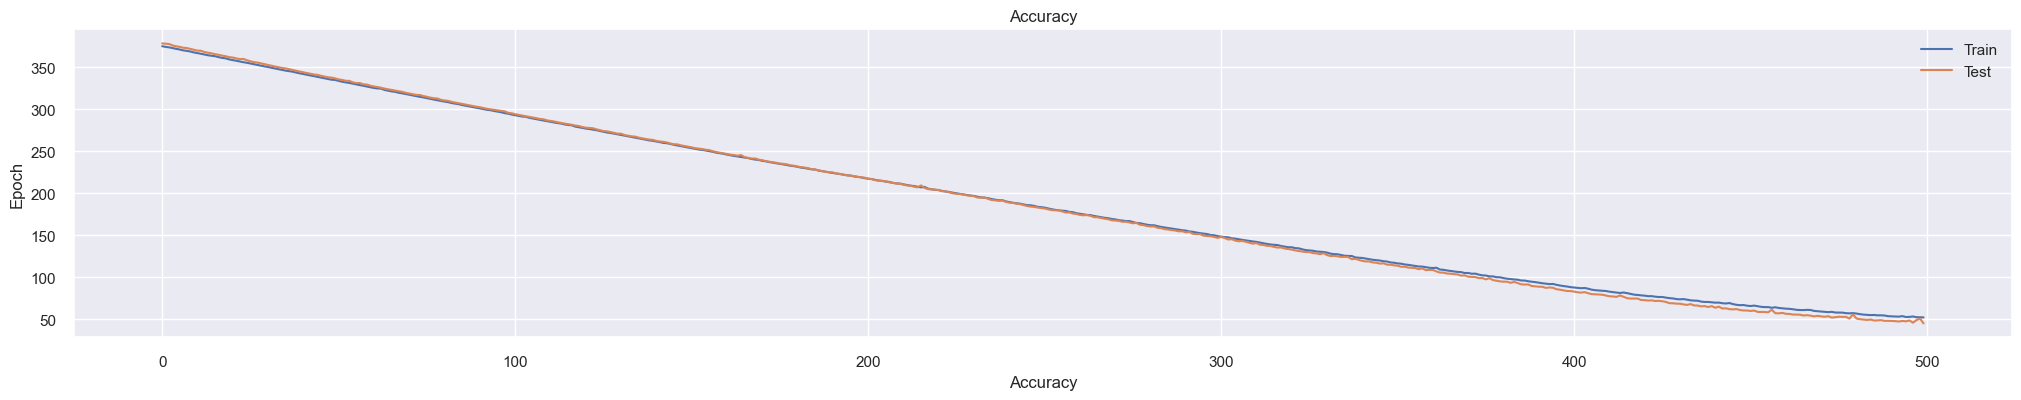

In [129]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [130]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : 0.93
Mean Squared Error : 14239.33


In [131]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

            Train Predictions  Actuals       Diff
Date                                             
2013-10-08        1293.088135  1321.00  27.911865
2018-10-10        1194.241699  1186.40   7.841699
2015-05-07        1186.684814  1183.00   3.684814
2010-03-19        1114.870728  1121.50   6.629272
2013-09-17        1292.899414  1317.25  24.350586
45.28651551017226 / 41980.599877929686


29/29 [==============================] - 0s 9ms/step


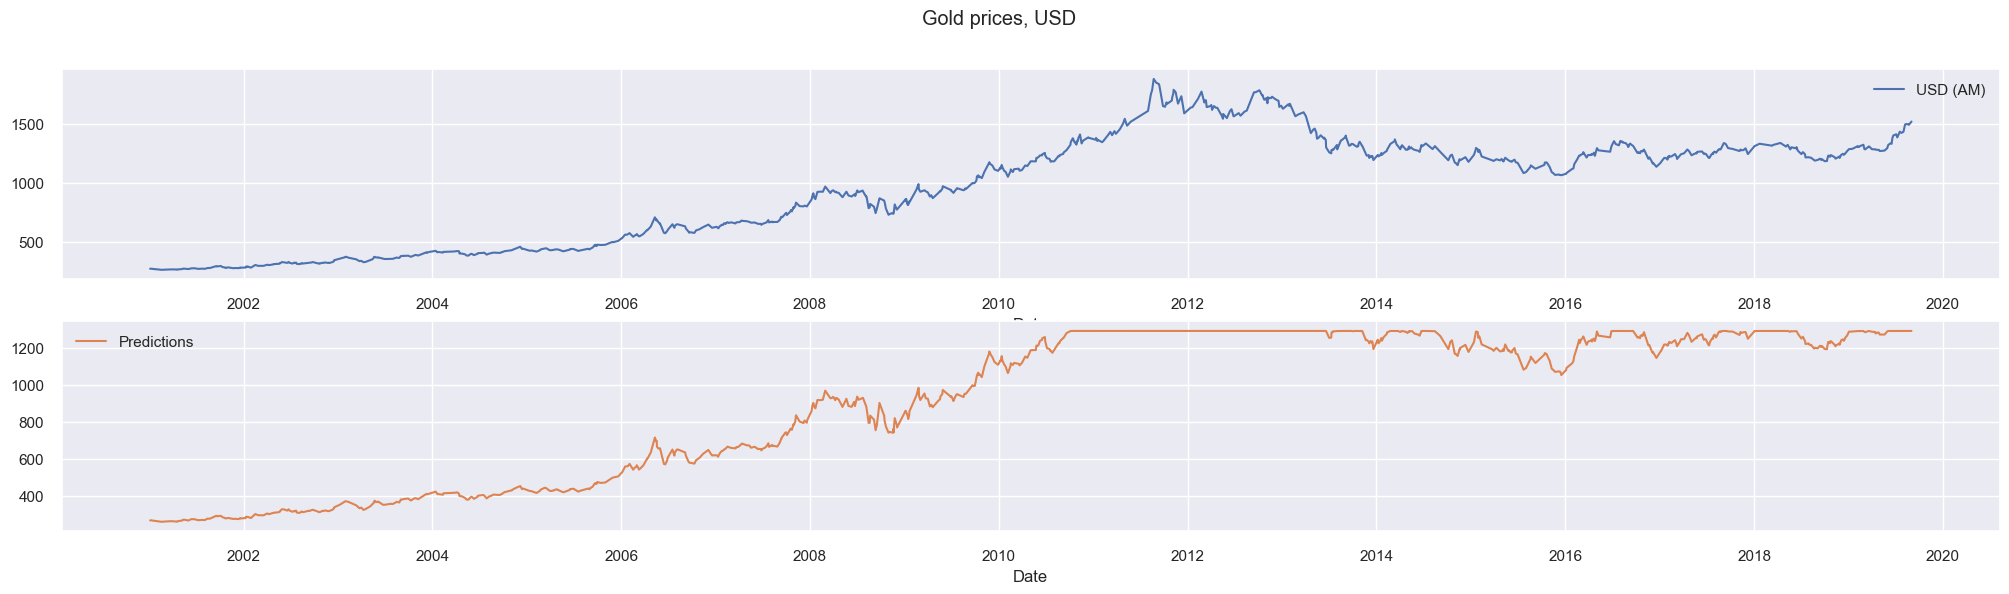

In [132]:
out_of_sample_results = y_test.to_frame()
out_of_sample_results["Predictions"] = model.predict(X_test)

fig, ax = plt.subplots(figsize=(25, 6))
out_of_sample_results.plot(ax=ax, subplots=True, title='Gold prices, USD')

plt.show()

# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [48]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('gradient', gradient),
], n_jobs=-1)

In [49]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [50]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : -2.86 %
Test Score         : -0.25 %
R Squared Error    : -0.0
Mean Squared Error : 0.54


In [52]:
train_predictions = (model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

            Train Predictions   Actuals      Diff
Date                                             
2019-01-02           0.116628  0.304926  0.188298
2019-01-03           0.049907  0.588510  0.538603
2019-01-04           0.018765 -0.817544  0.836310
2019-01-07           0.045756  0.961013  0.915257
2019-01-08           0.041138 -0.444978  0.486115
0.5192053952845596 / 87.74571180309056


### 6.2. Pycarets

In [13]:
s = RegressionExperiment()
s.setup(data, target = 'price', session_id = 123)

In [14]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:24:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)

In [16]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,284.1660,292688.2905,541.0067,0.9817,0.1070,0.0831


,carat,cut,color,clarity,depth,table,x,y,z,price,prediction_label
47295,0.30,1,2,3,63.400002,56.0,4.26,4.29,2.71,394,486.420649
52309,0.31,2,0,2,62.299999,56.0,4.32,4.35,2.70,548,682.183706
3825,0.73,2,1,4,61.400002,55.0,5.80,5.82,3.57,3471,3510.702591
45257,0.51,2,2,5,61.599998,57.0,5.14,5.15,3.17,1661,1652.668495
8585,1.01,4,5,5,61.299999,56.0,6.53,6.45,3.98,4438,4476.470241
...,...,...,...,...,...,...,...,...,...,...,...
13768,1.35,4,6,2,61.099998,61.0,7.10,7.13,4.35,5613,5533.372564
46340,0.50,1,0,5,63.700001,56.0,5.09,5.05,3.23,1758,1613.025171
47227,0.60,2,0,2,62.299999,57.0,5.42,5.37,3.36,1840,1804.547772
22661,1.26,2,2,5,61.500000,56.0,6.97,7.01,4.30,10709,9923.811775
